In [ ]:
!pip install h5py  # Required to save models in HDF5 format

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from keras.layers import TimeDistributed
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read the population dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
population_df = pd.read_csv('/content/drive/My Drive/Arquivo/Datasets/population.csv', header=0, index_col=0)

In [ ]:
population_df.head()

,Municípios,1991,1996,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Codigo,,,,,,,,,,,,,,,,,,,,,,,
1100015,Alta Floresta D'Oeste (RO),31980.0,33471.0,26511.0,26919,27237,27563,29001,28629,29005,23857.0,24577,24354,24392.0,24228,24069,25728,25652,25578,25506,25437,23167,22945
1100023,Ariquemes (RO),83684.0,68503.0,74329.0,76371,78039,79680,86901,85031,86924,82388.0,84581,85541,90353.0,91570,92747,101269,102860,104401,105896,107345,106168,107863
1100031,Cabixi (RO),8174.0,8263.0,7517.0,7501,7490,7478,7421,7436,7421,6575.0,6777,6695,6313.0,6221,6132,6495,6424,6355,6289,6224,5438,5312
1100049,Cacoal (RO),78934.0,72922.0,73527.0,73996,74381,74758,76417,75988,76422,76155.0,78263,78675,78574.0,78959,79330,85863,86556,87226,87877,88507,84813,85359
1100056,Cerejeiras (RO),21608.0,21157.0,18180.0,18012,17925,17794,17217,17366,17215,16290.0,16784,16622,17029.0,16939,16852,18041,18013,17986,17959,17934,16444,16323


In [ ]:
population_df.dtypes

Municípios     object
1991          float64
1996          float64
2000          float64
2001           object
2002           object
2003           object
2004           object
2005           object
2006           object
2007          float64
2008           object
2009           object
2010          float64
2011           object
2012            int64
2013            int64
2014            int64
2015            int64
2016            int64
2017            int64
2018            int64
2019            int64
dtype: object

In [ ]:
population_df[['2001', '2002', '2003', '2004', '2005', '2006', '2008', '2009', '2011']] = population_df[['2001', '2002', '2003', '2004', '2005', '2006', '2008', '2009', '2011']].stack().str.replace(',', '.').unstack()

In [ ]:
population_df.head()

,Municípios,1991,1996,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Codigo,,,,,,,,,,,,,,,,,,,,,,,
1100015,Alta Floresta D'Oeste (RO),31980.0,33471.0,26511.0,26919,27237,27563,29001,28629,29005,23857.0,24577,24354,24392.0,24228,24069,25728,25652,25578,25506,25437,23167,22945
1100023,Ariquemes (RO),83684.0,68503.0,74329.0,76371,78039,79680,86901,85031,86924,82388.0,84581,85541,90353.0,91570,92747,101269,102860,104401,105896,107345,106168,107863
1100031,Cabixi (RO),8174.0,8263.0,7517.0,7501,7490,7478,7421,7436,7421,6575.0,6777,6695,6313.0,6221,6132,6495,6424,6355,6289,6224,5438,5312
1100049,Cacoal (RO),78934.0,72922.0,73527.0,73996,74381,74758,76417,75988,76422,76155.0,78263,78675,78574.0,78959,79330,85863,86556,87226,87877,88507,84813,85359
1100056,Cerejeiras (RO),21608.0,21157.0,18180.0,18012,17925,17794,17217,17366,17215,16290.0,16784,16622,17029.0,16939,16852,18041,18013,17986,17959,17934,16444,16323


In [ ]:
population_df = population_df.replace("...", np.nan)

In [ ]:
population_df.iloc[:,1:] = population_df.iloc[:,1:].apply(pd.to_numeric)

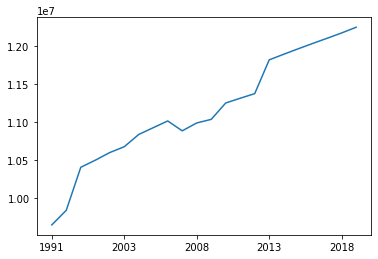

In [ ]:
population_df.loc[population_df['Municípios'] == 'São Paulo (SP)'].iloc[0,1:].plot()

## Engenharia de Dados

In [ ]:
#!pip install gspread
#!pip install oauth2client

In [ ]:
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
ibge_data_total = gc.open('IBGE Data')

In [ ]:
##IDHM
index = 0
df_aux = ibge_data_total.get_worksheet(index) 
data = df_aux.get_all_values()
headers = data.pop(0)
df_idhm = pd.DataFrame(data, columns=headers)
df_idhm = df_idhm.replace('...', np.nan)
df_idhm = df_idhm.set_index('Código')
for i in df_idhm.columns:
  if ('20' in i) or ('19' in i):
    df_idhm[i] = df_idhm[i].astype('float64')
df_idhm.head(3)

,Municípios,IDHM 1991,IDHM 2000,IDHM 2010,IDHM Renda 1991,IDHM Renda 2000,IDHM Renda 2010,IDHM Longevidade 1991,IDHM Longevidade 2000,IDHM Longevidade 2010,IDHM Educação 1991,IDHM Educação 2000,IDHM Educação 2010
Código,,,,,,,,,,,,,
76,Brasil,0.493,0.612,0.727,0.647,0.692,0.739,0.662,0.727,0.816,0.279,0.456,0.637
5200050,Abadia de Goiás,0.408,0.569,0.708,0.563,0.623,0.687,0.658,0.765,0.830,0.183,0.386,0.622
3100104,Abadia dos Dourados,0.449,0.575,0.689,0.551,0.616,0.693,0.728,0.799,0.839,0.225,0.387,0.563


In [ ]:
## Unidade Empresarias
index = 1
df_aux = ibge_data_total.get_worksheet(index) 
data = df_aux.get_all_values()[2:]
headers = data.pop(0)
df_empresas_old = pd.DataFrame(data[:], columns=headers)
df_empresas_old = df_empresas_old.replace('...', np.nan)
df_empresas_old = df_empresas_old.set_index('Código')
df_empresas_old.head(3)
for i in df_empresas_old.columns:
  if ('20' in i) or ('19' in i):
    df_empresas_old[i] = df_empresas_old[i].astype('float64')
df_empresas_old.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5564 entries, 1100015 to 5300108
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Municípios  5564 non-null   object 
 1   1996        5024 non-null   float64
 2   1997        5493 non-null   float64
 3   1998        5502 non-null   float64
 4   1999        5504 non-null   float64
 5   2000        5505 non-null   float64
 6   2001        5560 non-null   float64
 7   2002        5560 non-null   float64
 8   2003        5560 non-null   float64
 9   2004        5560 non-null   float64
 10  2005        5564 non-null   float64
 11  2006        5564 non-null   float64
dtypes: float64(11), object(1)
memory usage: 565.1+ KB


In [ ]:
## Nro Casamentos
index = 2
df_aux = ibge_data_total.get_worksheet(index) 
data = df_aux.get_all_values()[2:]
headers = data.pop(0)
df_casamentos = pd.DataFrame(data[:], columns=headers)
df_casamentos = df_casamentos.replace('...', np.nan)
df_casamentos = df_casamentos.set_index('Código')
for i in df_casamentos.columns:
  if ('20' in i) or ('19' in i):
    df_casamentos[i] = df_casamentos[i].astype('float64')
df_casamentos.head(3)

,Municípios,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Código,,,,,,,,,,,,,,,,,
1100015,Alta Floresta D'Oeste (RO),124.0,129.0,161.0,145.0,152.0,134.0,179.0,136.0,142.0,150.0,183.0,204.0,203.0,175.0,171.0,192.0
1100023,Ariquemes (RO),368.0,449.0,361.0,412.0,452.0,390.0,489.0,735.0,771.0,642.0,706.0,761.0,838.0,1007.0,980.0,665.0
1100031,Cabixi (RO),45.0,34.0,37.0,48.0,50.0,54.0,31.0,44.0,39.0,41.0,29.0,30.0,44.0,42.0,50.0,45.0


In [ ]:
#Variável - Salários e outras remunerações (Mil Reais)														
index = 4
df_aux = ibge_data_total.get_worksheet(index) 
data = df_aux.get_all_values()[2:]
headers = data.pop(0)
df_salarios = pd.DataFrame(data[:], columns=headers)
df_salarios = df_salarios.replace('...', np.nan)
df_salarios = df_salarios.replace('X', np.nan)
df_salarios = df_salarios.replace('-', np.nan)
df_salarios = df_salarios.set_index('Código')
for i in df_salarios.columns:
  if ('20' in i) or ('19' in i):
    df_salarios[i] = df_salarios[i].astype('float64')
df_salarios.head(3)

,Municípios,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Código,,,,,,,,,,,,,,
1100015,Alta Floresta D'Oeste (RO),13201.0,14643.0,17767.0,20423.0,24960.0,28939.0,33746.0,37769.0,42257.0,46459.0,55135.0,54002.0,52732.0
1100023,Ariquemes (RO),96098.0,109153.0,142171.0,170618.0,183190.0,216048.0,253296.0,288705.0,299988.0,321800.0,347135.0,377716.0,386576.0
1100031,Cabixi (RO),2321.0,2710.0,3399.0,4410.0,5158.0,5709.0,6560.0,7046.0,7244.0,7937.0,9548.0,10315.0,10209.0


In [ ]:
## População  
index = 5
df_aux = ibge_data_total.get_worksheet(index) 
data = df_aux.get_all_values()[:]
headers = data.pop(0)
df_populacao = pd.DataFrame(data[:], columns=headers)
df_populacao = df_populacao.replace('...', np.nan)
df_populacao = df_populacao.replace('', np.nan)
df_populacao = df_populacao.set_index('Código')
for i in df_populacao.columns:
  if ('20' in i) or ('19' in i):
    df_populacao[i] = df_populacao[i].astype('float64')
df_populacao.head(3)

,Municípios,1991,1996,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Código,,,,,,,,,,,,,,,,,,,,,,,
1100015,Alta Floresta D'Oeste (RO),31980.0,33471.0,26511.0,26919.0,27237.0,27563.0,29001.0,28629.0,29005.0,23857.0,24577.0,24354.0,24392.0,24228.0,24069.0,25728.0,25652.0,25578.0,25506.0,25437.0,23167.0,22945.0
1100023,Ariquemes (RO),83684.0,68503.0,74329.0,76371.0,78039.0,79680.0,86901.0,85031.0,86924.0,82388.0,84581.0,85541.0,90353.0,91570.0,92747.0,101269.0,102860.0,104401.0,105896.0,107345.0,106168.0,107863.0
1100031,Cabixi (RO),8174.0,8263.0,7517.0,7501.0,7490.0,7478.0,7421.0,7436.0,7421.0,6575.0,6777.0,6695.0,6313.0,6221.0,6132.0,6495.0,6424.0,6355.0,6289.0,6224.0,5438.0,5312.0


In [ ]:
## PIB
index = 6
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()
headers = data.pop(0)
df_pib = pd.DataFrame(data, columns=headers)
df_pib = df_pib.replace('...', np.nan)
df_pib = df_pib.set_index('Código')
for i in df_pib.columns:
  if ('20' in i) or ('19' in i):
    df_pib[i] = df_pib[i].astype('float64')
df_pib.head(3)

,Municípios,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Código,,,,,,,,,,,,,,,,,
1100015,Alta Floresta D'Oeste,111291.00,143222.38,173990.79,167127.36,168805.06,191364.33,248961.79,256986.14,262076.88,280509.58,329029.48,341324.69,377799.00,421299.98,478216.98,498864.19
1100023,Ariquemes,449592.82,539636.21,657193.23,749021.19,790696.63,905202.63,1064821.96,1133094.86,1364693.78,1651885.02,1703641.94,1799852.51,1921531.62,2037798.61,2184346.10,2296073.71
1100031,Cabixi,31767.52,40984.57,43392.50,49129.64,46883.82,49165.76,60587.71,69776.00,69611.11,77217.19,99586.48,96364.54,113477.40,116565.18,133342.25,138893.55


In [ ]:
df_pib.head()

,Municípios,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Código,,,,,,,,,,,,,,,,,
1100015,Alta Floresta D'Oeste,111291.00,143222.38,173990.79,167127.36,168805.06,191364.33,248961.79,256986.14,262076.88,280509.58,329029.48,341324.69,377799.00,421299.98,478216.98,498864.19
1100023,Ariquemes,449592.82,539636.21,657193.23,749021.19,790696.63,905202.63,1064821.96,1133094.86,1364693.78,1651885.02,1703641.94,1799852.51,1921531.62,2037798.61,2184346.10,2296073.71
1100031,Cabixi,31767.52,40984.57,43392.50,49129.64,46883.82,49165.76,60587.71,69776.00,69611.11,77217.19,99586.48,96364.54,113477.40,116565.18,133342.25,138893.55
1100049,Cacoal,474443.10,622437.19,622414.64,758959.55,743193.72,814890.27,928698.70,985478.84,1186494.09,1259024.29,1372705.09,1433253.51,1660649.61,1794477.51,1947282.54,2127523.25
1100056,Cerejeiras,79173.61,99983.39,121365.67,129106.97,124414.95,143269.95,167474.35,190902.13,222021.19,260142.10,357333.00,353269.68,392416.84,397736.13,408193.83,448524.17


In [ ]:
## Unidades Empresariais - Novo
index = 10
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[2:]
headers = data.pop(0)
df_empresas = pd.DataFrame(data, columns=headers)
df_empresas = df_empresas.replace('...', np.nan)
df_empresas = df_empresas.set_index('Código')
for i in df_empresas.columns:
  if ('20' in i) or ('19' in i):
    df_empresas[i] = df_empresas[i].astype('float64')
df_empresas.head(3)

,Municípios,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Código,,,,,,,,,,,,,,
1100015,Alta Floresta D'Oeste (RO),453.0,364.0,459.0,441.0,460.0,522.0,617.0,564.0,498.0,461.0,508.0,549.0,478.0
1100023,Ariquemes (RO),1614.0,1596.0,1840.0,1973.0,2075.0,1888.0,2048.0,2171.0,2147.0,2251.0,2221.0,2233.0,2252.0
1100031,Cabixi (RO),63.0,81.0,73.0,50.0,114.0,88.0,91.0,68.0,77.0,65.0,60.0,65.0,66.0


In [ ]:
## Pessoas Empregadas
index = 11
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[2:]
headers = data.pop(0)
df_empregadas = pd.DataFrame(data, columns=headers)
df_empregadas = df_empregadas.replace('...', np.nan)
df_empregadas = df_empregadas.replace('X', np.nan)
df_empregadas = df_empregadas.replace('-', np.nan)
df_empregadas = df_empregadas.replace('', np.nan)
df_empregadas = df_empregadas.set_index('Código')
for i in df_empregadas.columns:
  if ('20' in i) or ('19' in i):
    df_empregadas[i] = df_empregadas[i].astype('float64')
df_empregadas.head(3)

,Municípios,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Código,,,,,,,,,,,,,,
1100015,Alta Floresta D'Oeste (RO),2138.0,2170.0,2294.0,2487.0,2626.0,2721.0,2804.0,3262.0,3110.0,3028.0,3299.0,3255.0,3156.0
1100023,Ariquemes (RO),12490.0,13371.0,15453.0,16552.0,16572.0,17594.0,18424.0,19382.0,19420.0,19102.0,18488.0,18876.0,19002.0
1100031,Cabixi (RO),362.0,407.0,363.0,450.0,486.0,468.0,553.0,513.0,503.0,514.0,590.0,582.0,533.0


In [ ]:
## Pessoas Assalariadas
index = 12
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[2:]
headers = data.pop(0)
df_assalariadas = pd.DataFrame(data, columns=headers)
df_assalariadas = df_assalariadas.replace('...', np.nan)
df_assalariadas = df_assalariadas.replace('X', np.nan)
df_assalariadas = df_assalariadas.replace('-', np.nan)
df_assalariadas = df_assalariadas.replace('', np.nan)
df_assalariadas = df_assalariadas.set_index('Código')
for i in df_assalariadas.columns:
  if ('20' in i) or ('19' in i):
    df_assalariadas[i] = df_assalariadas[i].astype('float64')
df_assalariadas.head(3)

,Municípios,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Código,,,,,,,,,,,,,,
1100015,Alta Floresta D'Oeste (RO),1673.0,1666.0,1722.0,1866.0,2087.0,2099.0,2120.0,2652.0,2485.0,2446.0,2625.0,2511.0,2487.0
1100023,Ariquemes (RO),10244.0,11061.0,12726.0,13751.0,13605.0,14905.0,15545.0,16322.0,16350.0,15886.0,15280.0,15641.0,15678.0
1100031,Cabixi (RO),293.0,325.0,303.0,391.0,379.0,403.0,440.0,454.0,429.0,436.0,485.0,490.0,464.0


In [ ]:
## Produto Interno Bruto a preços correntes (Mil Reais)
index = 13
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[3:]
headers = data.pop(0)
df_pib_correntes_1 = pd.DataFrame(data, columns=headers)
df_pib_correntes_1 = df_pib_correntes_1.replace('...', np.nan)
df_pib_correntes_1 = df_pib_correntes_1.set_index('Código')
for i in df_pib_correntes_1.columns:
  if ('20' in i) or ('19' in i):
    df_pib_correntes_1[i] = df_pib_correntes_1[i].astype('float64')
df_pib_correntes_1.head(3)

,Municípios,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Código,,,,,,,,,,,,,,,,,
1,Brasil,1.488787e+09,1.717950e+09,1.957751e+09,2.170585e+09,2.409450e+09,2.720263e+09,3.109803e+09,3.333039e+09,3.885847e+09,4.376382e+09,4.814760e+09,5.331619e+09,5.778953e+09,5.995787e+09,6.269328e+09,6.583319e+09
1100015,Alta Floresta D'Oeste (RO),1.112910e+05,1.432220e+05,1.739910e+05,1.671270e+05,1.688050e+05,1.913640e+05,2.489620e+05,2.569860e+05,2.620770e+05,2.805100e+05,3.290290e+05,3.413250e+05,3.777990e+05,4.213000e+05,4.782170e+05,4.988640e+05
1100023,Ariquemes (RO),4.495930e+05,5.396360e+05,6.571930e+05,7.490210e+05,7.906970e+05,9.052030e+05,1.064822e+06,1.133095e+06,1.364694e+06,1.651885e+06,1.703642e+06,1.799853e+06,1.921532e+06,2.037799e+06,2.184346e+06,2.296074e+06


In [ ]:
#Variável - Valor adicionado bruto a preços correntes da agropecuária (Mil Reais)
index = 14
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[3:]
headers = data.pop(0)
df_pib_agropecuaria = pd.DataFrame(data, columns=headers)
df_pib_agropecuaria = df_pib_agropecuaria.replace('...', np.nan)
df_pib_agropecuaria = df_pib_agropecuaria.set_index('Código')
for i in df_pib_agropecuaria.columns:
  if ('20' in i) or ('19' in i):
    df_pib_agropecuaria[i] = df_pib_agropecuaria[i].astype('float64')
df_pib_agropecuaria.head(3)

,Municípios,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Código,,,,,,,,,,,,,,,,,
1,Brasil,81515199.0,105949165.0,110912703.0,100957547.0,105294011.0,120151715.0,142051182.0,149212635.0,159932000.0,190024000.0,200695000.0,240290000.0,249975000.0,258967000.0,306655000.0,302971000.0
1100015,Alta Floresta D'Oeste (RO),27013.0,41079.0,41413.0,41524.0,39469.0,52003.0,77093.0,77002.0,69260.0,73328.0,106125.0,110851.0,122731.0,146407.0,166143.0,169623.0
1100023,Ariquemes (RO),28590.0,47308.0,46853.0,46367.0,42170.0,47866.0,64917.0,67707.0,73712.0,80517.0,96495.0,93250.0,110862.0,129657.0,145069.0,165217.0


In [ ]:
#Variável - Valor adicionado bruto a preços correntes da indústria (Mil Reais)
index = 15
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[3:]
headers = data.pop(0)
df_pib_industria = pd.DataFrame(data, columns=headers)
df_pib_industria = df_pib_industria.replace('...', np.nan)
df_pib_industria = df_pib_industria.set_index('Código')
for i in df_pib_industria.columns:
  if ('20' in i) or ('19' in i):
    df_pib_industria[i] = df_pib_industria[i].astype('float64')
df_pib_industria.head(3)

,Municípios,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Código,,,,,,,,,,,,,,,,,
1,Brasil,334907570.0,396568543.0,475863218.0,524686244.0,567281406.0,629071171.0,717907186.0,729222075.0,904158000.0,1.011034e+09,1.065682e+09,1.131626e+09,1.183094e+09,1.160787e+09,1.150720e+09,1.196931e+09
1100015,Alta Floresta D'Oeste (RO),9377.0,12701.0,29963.0,13391.0,12885.0,12475.0,14529.0,14831.0,16119.0,1.794200e+04,1.890600e+04,2.033700e+04,2.204800e+04,2.064300e+04,3.159800e+04,2.780500e+04
1100023,Ariquemes (RO),99923.0,107718.0,141387.0,139522.0,152518.0,192678.0,205835.0,185424.0,287139.0,3.797980e+05,3.086340e+05,3.547330e+05,3.475220e+05,3.200170e+05,3.542870e+05,3.303190e+05


In [ ]:
#Variável - Impostos, líquidos de subsídios, sobre produtos a preços correntes (Mil Reais)
index = 16
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[3:]
headers = data.pop(0)
df_pib_produtos = pd.DataFrame(data, columns=headers)
df_pib_produtos = df_pib_produtos.replace('...', np.nan)
df_pib_produtos = df_pib_produtos.set_index('Código')
for i in df_pib_produtos.columns:
  if ('20' in i) or ('19' in i):
    df_pib_produtos[i] = df_pib_produtos[i].astype('float64')
df_pib_produtos.head(3)

,Municípios,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Código,,,,,,,,,,,,,,,,,
1,Brasil,218572609.0,247233152.0,295769101.0,327766101.0,360159938.0,400734670.0,483325381.0,483276517.0,583007000.0,655921000.0,720501000.0,777858957.0,806218780.0,840186000.0,849506000.0,913553000.0
1100015,Alta Floresta D'Oeste (RO),7549.0,10512.0,12219.0,12934.0,13669.0,15974.0,20292.0,18874.0,20957.0,21215.0,19880.0,16776.0,18793.0,23228.0,23202.0,28793.0
1100023,Ariquemes (RO),42666.0,53928.0,68381.0,85363.0,100421.0,105935.0,124094.0,133461.0,165030.0,206128.0,202427.0,190305.0,195603.0,217467.0,216460.0,232012.0


In [ ]:
#Variável - Valor adicionado bruto a preços correntes total (Mil Reais)
index = 17
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[3:]
headers = data.pop(0)
df_pib_correntes_2 = pd.DataFrame(data, columns=headers)
df_pib_correntes_2 = df_pib_correntes_2.replace('...', np.nan)
df_pib_correntes_2 = df_pib_correntes_2.set_index('Código')
for i in df_pib_correntes_2.columns:
  if ('20' in i) or ('19' in i):
    df_pib_correntes_2[i] = df_pib_correntes_2[i].astype('float64')
df_pib_correntes_2.head(3)

,Municípios,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Código,,,,,,,,,,,,,,,,,
1,Brasil,1.270215e+09,1.470717e+09,1.661982e+09,1.842818e+09,2.049290e+09,2.319528e+09,2.626478e+09,2.849763e+09,3.302840e+09,3.720461e+09,4.094259e+09,4.553760e+09,4.972734e+09,5.155601e+09,5.419822e+09,5.669766e+09
1100015,Alta Floresta D'Oeste (RO),1.037420e+05,1.327110e+05,1.617720e+05,1.541940e+05,1.551360e+05,1.753910e+05,2.286700e+05,2.381120e+05,2.411200e+05,2.592950e+05,3.091500e+05,3.245490e+05,3.590060e+05,3.980720e+05,4.550140e+05,4.700720e+05
1100023,Ariquemes (RO),4.069270e+05,4.857090e+05,5.888120e+05,6.636580e+05,6.902760e+05,7.992680e+05,9.407280e+05,9.996330e+05,1.199664e+06,1.445757e+06,1.501215e+06,1.609548e+06,1.725928e+06,1.820331e+06,1.967886e+06,2.064062e+06


In [ ]:
#Variável - Valor adicionado bruto a preços correntes dos serviços, exclusive administração, defesa, educação e saúde públicas e seguridade social (Mil Reais)
index = 18
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[3:]
headers = data.pop(0)
df_pib_sociedade_1 = pd.DataFrame(data, columns=headers)
df_pib_sociedade_1 = df_pib_sociedade_1.replace('...', np.nan)
df_pib_sociedade_1 = df_pib_sociedade_1.set_index('Código')
for i in df_pib_sociedade_1.columns:
  if ('20' in i) or ('19' in i):
    df_pib_sociedade_1[i] = df_pib_sociedade_1[i].astype('float64')
df_pib_sociedade_1.head(3)

,Municípios,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Código,,,,,,,,,,,,,,,,,
1,Brasil,644403214.0,732543684.0,815527583.0,922044705.0,1.043095e+09,1.193195e+09,1.332297e+09,1.484149e+09,1.700905e+09,1.921344e+09,2.175781e+09,2.435657e+09,2.722857e+09,2.850260e+09,3.017326e+09,3.168889e+09
1100015,Alta Floresta D'Oeste (RO),24651.0,32976.0,39090.0,39585.0,3.639900e+04,4.637200e+04,6.080300e+04,6.108300e+04,6.249600e+04,6.548600e+04,7.133000e+04,7.302500e+04,8.775100e+04,9.877900e+04,1.145410e+05,1.177170e+05
1100023,Ariquemes (RO),161852.0,201089.0,251591.0,298604.0,2.918400e+05,3.385780e+05,4.081290e+05,4.446530e+05,4.949460e+05,6.099540e+05,6.806750e+05,6.948320e+05,7.799410e+05,8.461880e+05,8.795550e+05,9.339350e+05


In [ ]:
#Variável - Valor adicionado bruto a preços correntes da administração, defesa, educação e saúde públicas e seguridade social (Mil Reais)
index = 19
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[3:]
headers = data.pop(0)
df_pib_sociedade_2 = pd.DataFrame(data, columns=headers)
df_pib_sociedade_2 = df_pib_sociedade_2.replace('...', np.nan)
df_pib_sociedade_2 = df_pib_sociedade_2.set_index('Código')
for i in df_pib_sociedade_2.columns:
  if ('20' in i) or ('19' in i):
    df_pib_sociedade_2[i] = df_pib_sociedade_2[i].astype('float64')
df_pib_sociedade_2.head(3)

,Municípios,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Código,,,,,,,,,,,,,,,,,
1,Brasil,209388684.0,235655842.0,259678619.0,295129906.0,333619786.0,377110174.0,434222689.0,487178806.0,537845000.0,598059000.0,652101000.0,746187000.0,816808000.0,885587000.0,945121000.0,1.000975e+09
1100015,Alta Floresta D'Oeste (RO),42701.0,45955.0,51306.0,59693.0,66383.0,64541.0,76245.0,85196.0,93245.0,102539.0,112789.0,120336.0,126477.0,132243.0,142733.0,1.549260e+05
1100023,Ariquemes (RO),116562.0,129594.0,148981.0,179165.0,203748.0,220146.0,261846.0,301848.0,343868.0,375488.0,415411.0,466733.0,487603.0,524470.0,588975.0,6.345910e+05


In [ ]:
# LatLong + Código UF
index = 20
name_worksheet_aux = ibge_data_total.worksheets()[index].title
worksheet_aux = ibge_data_total.get_worksheet(index) 
data = worksheet_aux.get_all_values()[:]
headers = data.pop(0)
df_latlong = pd.DataFrame(data, columns=headers)
df_latlong = df_latlong.set_index('Código')
df_latlong.head(3)
df_latlong['Latitude'] = df_latlong['Latitude'].astype('float64')
df_latlong['Longitude'] = df_latlong['Longitude'].astype('float64')

## Deep learning model

In [ ]:
df = population_df.iloc[1:, 1:]

In [ ]:
df.head()

,1991,1996,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Codigo,,,,,,,,,,,,,,,,,,,,,,
1100023,83684.0,68503.0,74329.0,76371.0,78039.0,79680.0,86901.0,85031.0,86924.0,82388.0,84581.0,85541.0,90353.0,91570.0,92747,101269,102860,104401,105896,107345,106168,107863
1100031,8174.0,8263.0,7517.0,7501.0,7490.0,7478.0,7421.0,7436.0,7421.0,6575.0,6777.0,6695.0,6313.0,6221.0,6132,6495,6424,6355,6289,6224,5438,5312
1100049,78934.0,72922.0,73527.0,73996.0,74381.0,74758.0,76417.0,75988.0,76422.0,76155.0,78263.0,78675.0,78574.0,78959.0,79330,85863,86556,87226,87877,88507,84813,85359
1100056,21608.0,21157.0,18180.0,18012.0,17925.0,17794.0,17217.0,17366.0,17215.0,16290.0,16784.0,16622.0,17029.0,16939.0,16852,18041,18013,17986,17959,17934,16444,16323
1100064,38993.0,24955.0,21998.0,21421.0,20881.0,20412.0,18349.0,18883.0,18342.0,17644.0,18216.0,17822.0,18591.0,18338.0,18093,19190,19001,18817,18639,18467,16227,15882


In [ ]:
df = df.dropna()

In [ ]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [ ]:
X.head(), X.shape

(            1991     1996     2000     2001  ...    2015    2016    2017    2018
 Codigo                                       ...                                
 1100023  83684.0  68503.0  74329.0  76371.0  ...  104401  105896  107345  106168
 1100031   8174.0   8263.0   7517.0   7501.0  ...    6355    6289    6224    5438
 1100049  78934.0  72922.0  73527.0  73996.0  ...   87226   87877   88507   84813
 1100056  21608.0  21157.0  18180.0  18012.0  ...   17986   17959   17934   16444
 1100064  38993.0  24955.0  21998.0  21421.0  ...   18817   18639   18467   16227
 
 [5 rows x 21 columns], (4490, 21))

In [ ]:
y.head(), y.shape

(Codigo
 1100023    107863
 1100031      5312
 1100049     85359
 1100056     16323
 1100064     15882
 Name: 2019, dtype: int64, (4490,))

In [ ]:
X = np.asarray(X).astype('float32')

In [ ]:
X.shape

(4490, 21)

In [ ]:
X[0]

array([ 83684.,  68503.,  74329.,  76371.,  78039.,  79680.,  86901.,
        85031.,  86924.,  82388.,  84581.,  85541.,  90353.,  91570.,
        92747., 101269., 102860., 104401., 105896., 107345., 106168.],
      dtype=float32)

In [ ]:
y = np.asarray(y).astype('float32')

In [ ]:
y.shape

(4490,)

In [ ]:
y[0]

107863.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [ ]:
scaler = StandardScaler()
scaler2 = StandardScaler()

In [ ]:
X_train = np.squeeze(X_train)

In [ ]:
X_test = np.squeeze(X_test)

In [ ]:
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [ ]:
X_train = scaler.fit_transform(X_train)
y_train = scaler2.fit_transform(y_train)

In [ ]:
X_test, y_test = scaler.transform(X_test), scaler2.transform(y_test)

### Single layer LSTM model

In [ ]:
# Number of time steps
n_steps = 21

# Number of features
n_features = 1

# Reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')

Epoch 1/10
85/85 [==============================] - 3s 31ms/step - loss: 0.1147 - val_loss: 0.0456
Epoch 2/10
85/85 [==============================] - 3s 31ms/step - loss: 0.0311 - val_loss: 0.1229
Epoch 3/10
85/85 [==============================] - 3s 31ms/step - loss: 0.0298 - val_loss: 0.0289
Epoch 4/10
85/85 [==============================] - 3s 31ms/step - loss: 0.0210 - val_loss: 0.0359
Epoch 5/10
85/85 [==============================] - 3s 35ms/step - loss: 0.0193 - val_loss: 0.0283
Epoch 6/10
85/85 [==============================] - 3s 33ms/step - loss: 0.0190 - val_loss: 0.0349
Epoch 7/10
85/85 [==============================] - 3s 31ms/step - loss: 0.0185 - val_loss: 0.0153
Epoch 8/10
85/85 [==============================] - 3s 30ms/step - loss: 0.0179 - val_loss: 0.0222
Epoch 9/10
85/85 [==============================] - 3s 36ms/step - loss: 0.0174 - val_loss: 0.0225
Epoch 10/10
85/85 [==============================] - 3s 35ms/step - loss: 0.0154 - val_loss: 0.0204


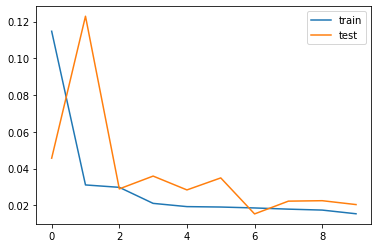

In [ ]:
# Training
history = model.fit(X_train, y_train, epochs=10, validation_split=0.10, verbose=1)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
X_input = X_train[0]
y_target = y_train[0]
X_input = X_input.reshape((1, n_steps, n_features))
pred = model.predict(X_input, verbose=0)[0][0]
print("Prediction: ", scaler2.inverse_transform(pred.reshape(-1,1))[0][0])
print("Actual: ", scaler2.inverse_transform(y_target)[0])

Prediction:  3783.747
Actual:  5924.001


In [ ]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
preds = model.predict(X_test, verbose=0)

In [ ]:
print("MAE", mean_absolute_error(y_test, preds))
print("RMSE", sqrt(mean_squared_error(y_test, preds)))

MAE 0.059047002
RMSE 1.338830681657217


In [ ]:
model.save('/content/drive/My Drive/time-series-models/single-layer-lstm.h5')

### Stacked LSTM model

In [ ]:
# Number of time steps
n_steps = 21

# Number of features
n_features = 1

# Reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Model
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')

In [ ]:
# Training
history = model.fit(X_train, y_train, epochs=10, validation_split=0.05, verbose=1)

Epoch 1/10
90/90 [==============================] - 6s 67ms/step - loss: 0.1532 - val_loss: 0.0315
Epoch 2/10
90/90 [==============================] - 6s 67ms/step - loss: 0.0438 - val_loss: 0.0454
Epoch 3/10
90/90 [==============================] - 5s 59ms/step - loss: 0.0344 - val_loss: 0.0283
Epoch 4/10
90/90 [==============================] - 6s 62ms/step - loss: 0.0299 - val_loss: 0.0260
Epoch 5/10
90/90 [==============================] - 6s 64ms/step - loss: 0.0285 - val_loss: 0.0249
Epoch 6/10
90/90 [==============================] - 6s 61ms/step - loss: 0.0375 - val_loss: 0.0178
Epoch 7/10
90/90 [==============================] - 5s 60ms/step - loss: 0.0261 - val_loss: 0.0161
Epoch 8/10
90/90 [==============================] - 6s 62ms/step - loss: 0.0240 - val_loss: 0.0267
Epoch 9/10
90/90 [==============================] - 6s 61ms/step - loss: 0.0225 - val_loss: 0.0150
Epoch 10/10
90/90 [==============================] - 6s 63ms/step - loss: 0.0229 - val_loss: 0.0230


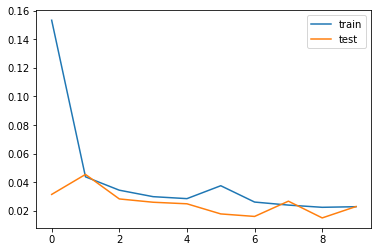

In [ ]:
# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
X_input = X_train[0]
y_target = y_train[0]
X_input = X_input.reshape((1, n_steps, n_features))
pred = model.predict(X_input, verbose=0)[0][0]
print("Prediction: ", scaler2.inverse_transform(pred.reshape(-1,1))[0][0])
print("Actual: ", scaler2.inverse_transform(y_target)[0])

Prediction:  8122.952
Actual:  5924.001


In [ ]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
preds = model.predict(X_test, verbose=0)

In [ ]:
print("MAE", mean_absolute_error(y_test, preds))
print("RMSE", sqrt(mean_squared_error(y_test, preds)))

MAE 0.033371393
RMSE 0.2533794219407938


### Add more layers and neurons

In [ ]:
# Number of time steps
n_steps = 21

# Number of features
n_features = 1

# Reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Model
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')

In [ ]:
# Training
history = model.fit(X_train, y_train, epochs=10, validation_split=0.05, verbose=1)

Epoch 1/10
90/90 [==============================] - 6s 62ms/step - loss: 0.1049 - val_loss: 0.0205
Epoch 2/10
90/90 [==============================] - 5s 60ms/step - loss: 0.0418 - val_loss: 0.0299
Epoch 3/10
90/90 [==============================] - 6s 62ms/step - loss: 0.0347 - val_loss: 0.0261
Epoch 4/10
90/90 [==============================] - 6s 66ms/step - loss: 0.0304 - val_loss: 0.0198
Epoch 5/10
90/90 [==============================] - 6s 61ms/step - loss: 0.0293 - val_loss: 0.0299
Epoch 6/10
90/90 [==============================] - 6s 65ms/step - loss: 0.0262 - val_loss: 0.0101
Epoch 7/10
90/90 [==============================] - 6s 61ms/step - loss: 0.0245 - val_loss: 0.0127
Epoch 8/10
90/90 [==============================] - 5s 59ms/step - loss: 0.0245 - val_loss: 0.0187
Epoch 9/10
90/90 [==============================] - 5s 60ms/step - loss: 0.0222 - val_loss: 0.0132
Epoch 10/10
90/90 [==============================] - 6s 63ms/step - loss: 0.0205 - val_loss: 0.0233


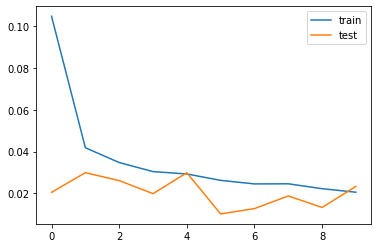

In [ ]:
# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
X_input = X_train[0]
y_target = y_train[0]
X_input = X_input.reshape((1, n_steps, n_features))
pred = model.predict(X_input, verbose=0)[0][0]
print("Prediction: ", scaler2.inverse_transform(pred.reshape(-1,1))[0][0])
print("Actual: ", scaler2.inverse_transform(y_target)[0])

Prediction:  4615.411
Actual:  5924.001


In [ ]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
preds = model.predict(X_test, verbose=0)

In [ ]:
print("MAE", mean_absolute_error(y_test, preds))
print("RMSE", sqrt(mean_squared_error(y_test, preds)))

MAE 0.038398
RMSE 0.3578178213798255


### Bidirectional LSTM model

In [ ]:
# Number of time steps
n_steps = 21

# Number of features
n_features = 1

# Reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Model
model = Sequential()
model.add(Bidirectional(LSTM(32, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')

Epoch 1/10
85/85 [==============================] - 5s 64ms/step - loss: 0.0958 - val_loss: 0.0458
Epoch 2/10
85/85 [==============================] - 6s 67ms/step - loss: 0.0388 - val_loss: 0.0309
Epoch 3/10
85/85 [==============================] - 5s 59ms/step - loss: 0.0320 - val_loss: 0.0393
Epoch 4/10
85/85 [==============================] - 5s 62ms/step - loss: 0.0294 - val_loss: 0.0278
Epoch 5/10
85/85 [==============================] - 5s 62ms/step - loss: 0.0267 - val_loss: 0.0238
Epoch 6/10
85/85 [==============================] - 5s 61ms/step - loss: 0.0257 - val_loss: 0.0238
Epoch 7/10
85/85 [==============================] - 5s 59ms/step - loss: 0.0227 - val_loss: 0.0303
Epoch 8/10
85/85 [==============================] - 5s 63ms/step - loss: 0.0224 - val_loss: 0.0239
Epoch 9/10
85/85 [==============================] - 5s 64ms/step - loss: 0.0218 - val_loss: 0.0301
Epoch 10/10
85/85 [==============================] - 5s 64ms/step - loss: 0.0207 - val_loss: 0.0211


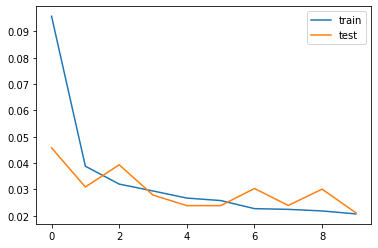

In [ ]:
# Training
history = model.fit(X_train, y_train, epochs=10, validation_split=0.10, verbose=1)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
X_input = X_train[0]
y_target = y_train[0]
X_input = X_input.reshape((1, n_steps, n_features))
pred = model.predict(X_input, verbose=0)[0][0]
print("Prediction: ", scaler2.inverse_transform(pred.reshape(-1,1))[0][0])
print("Actual: ", scaler2.inverse_transform(y_target)[0])

Prediction:  3835.8096
Actual:  5924.001


In [ ]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
preds = model.predict(X_test, verbose=0)

In [ ]:
print("MAE", mean_absolute_error(y_test, preds))
print("RMSE", sqrt(mean_squared_error(y_test, preds)))

MAE 0.08746777
RMSE 1.975826624013299
